# Problem understanding : `BRAIN STROKE CLASSIFIER`

# In[0]: IMPORT AND FUNCTIONS

In [1]:
import warnings 
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import re
import string
from collections import Counter
import time

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import iplot, init_notebook_mode
from plotly.subplots import make_subplots

%matplotlib inline
init_notebook_mode(connected= True)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn import svm, datasets
from sklearn.metrics import classification_report ,f1_score,precision_score,recall_score,roc_auc_score
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, plot_roc_curve


# In[1]: PART 1. LOOK AT THE BIG PICTURE (DONE)

# In[2]: PART 2. GET THE DATA (DONE). LOAD DATA

In [2]:
data=pd.read_csv("./brain_stroke.csv")

### `Brain Stroke Classifier`

* Attribute Information
    - gender: "Male", "Female" or "Other"
    - age: age of the patient
    - hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
    - heart disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease 5) ever-married: "No" or "Yes"
    - worktype: "children", "Govtjov", "Neverworked", "Private" or "Self-employed" 7) 
    - Residencetype: "Rural" or "Urban"
    - avgglucoselevel: average glucose level in blood
    - bmi: body mass index
    - smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
    - stroke: 1 if the patient had a stroke or 0 if not
    
More Information
* For BMI levels:
    - below 18.5 : you're in the underweight range
    - between 18.5 and 24.9 : you're in the healthy weight range
    - between 25 and 29.9 : you're in the overweight range
    - between 30 and 39.9 : you're in the obese range
* For glucose levels:
    - A fasting blood sugar level of 99 mg/dL or lower is normal
    - 100 to 125 mg/dL indicates you have prediabetes
    - 126 mg/dL or higher indicates you have diabetes

# In[3]: PART 3. DISCOVER THE DATA TO GAIN INSIGHTS

## Quick view of the data

In [3]:
# Numbers of columns in data set
print(f"We have {len(data.columns)} columns")
print(f"Include: ",data.columns.to_list())

We have 11 columns
Include:  ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']


In [4]:
data.head(5)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


## Preprocessing data

In [5]:
cols_need_replace=["hypertension","heart_disease","stroke"] 

In [6]:
for col in cols_need_replace:
    data[col]=data[col].replace({0:"No",1:"Yes"}) # convert 0 to "No" and 1 to "yes":
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,No,Yes,Yes,Private,Urban,228.69,36.6,formerly smoked,Yes
1,Male,80.0,No,Yes,Yes,Private,Rural,105.92,32.5,never smoked,Yes
2,Female,49.0,No,No,Yes,Private,Urban,171.23,34.4,smokes,Yes
3,Female,79.0,Yes,No,Yes,Self-employed,Rural,174.12,24.0,never smoked,Yes
4,Male,81.0,No,No,Yes,Private,Urban,186.21,29.0,formerly smoked,Yes


In [7]:
print("Statistics of categorical features")
data.describe(exclude=np.number)

Statistics of categorical features


,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,stroke
count,4981,4981,4981,4981,4981,4981,4981,4981
unique,2,2,2,2,4,2,4,2
top,Female,No,No,Yes,Private,Urban,never smoked,No
freq,2907,4502,4706,3280,2860,2532,1838,4733


In [8]:
print("Statistics numerical_features")
data.describe(include=np.number)

Statistics numerical_features


,age,avg_glucose_level,bmi
count,4981.000000,4981.000000,4981.000000
mean,43.419859,105.943562,28.498173
std,22.662755,45.075373,6.790464
min,0.080000,55.120000,14.000000
25%,25.000000,77.230000,23.700000
50%,45.000000,91.850000,28.100000
75%,61.000000,113.860000,32.600000
max,82.000000,271.740000,48.900000


## Checking null features

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4981 non-null   object 
 1   age                4981 non-null   float64
 2   hypertension       4981 non-null   object 
 3   heart_disease      4981 non-null   object 
 4   ever_married       4981 non-null   object 
 5   work_type          4981 non-null   object 
 6   Residence_type     4981 non-null   object 
 7   avg_glucose_level  4981 non-null   float64
 8   bmi                4981 non-null   float64
 9   smoking_status     4981 non-null   object 
 10  stroke             4981 non-null   object 
dtypes: float64(3), object(8)
memory usage: 428.2+ KB


In [10]:
data.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

This dataset have not null values

## Check duplicated values

In [11]:

data[data.duplicated()]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke


## Exploring Data Analysis

In [12]:
target_feature="stroke"

In [13]:
df=data.copy()


In [14]:
categorical_col=[col for col in df.select_dtypes(include=["object"]).columns.to_list() if col !=target_feature] # Extrac categorical columns in dataset

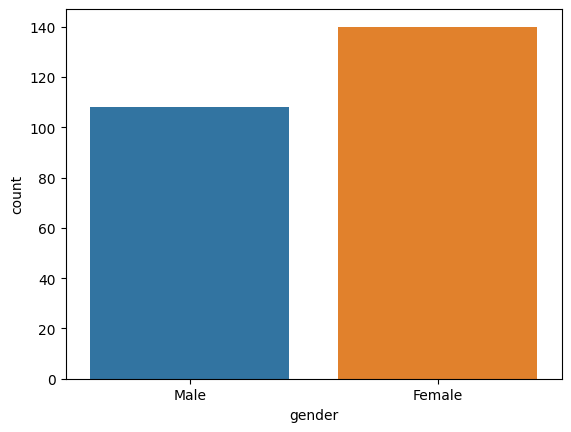

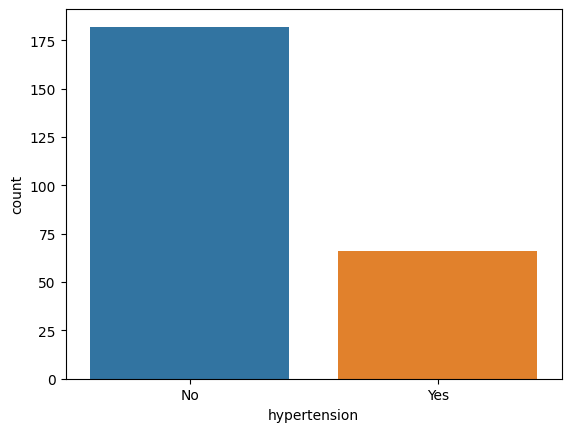

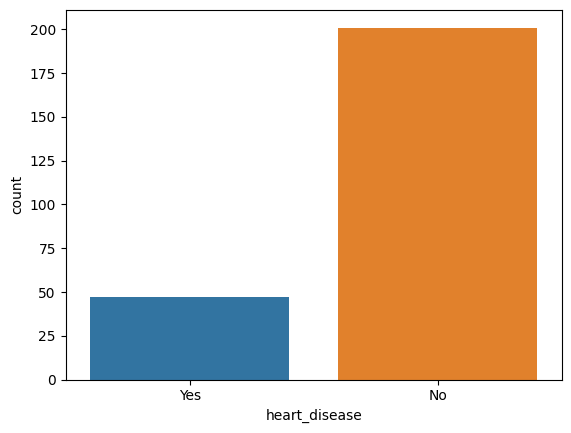

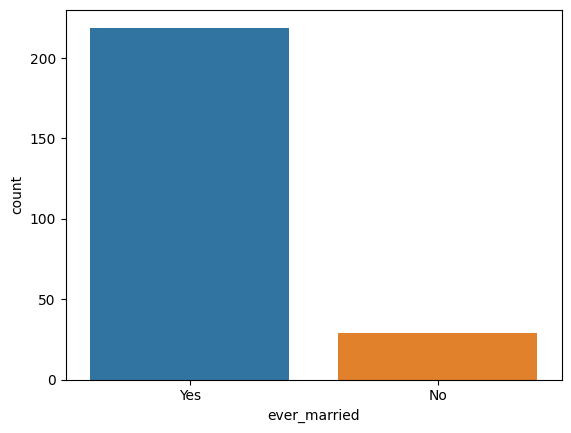

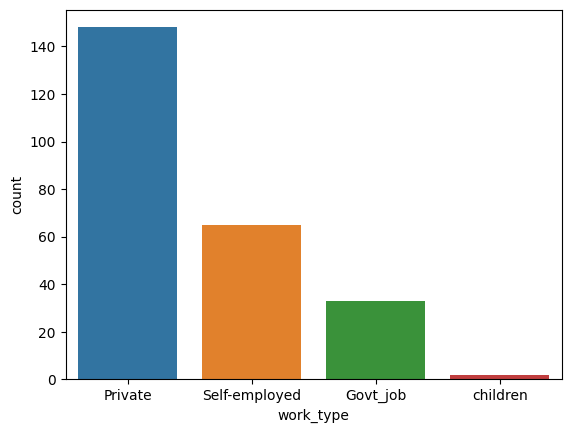

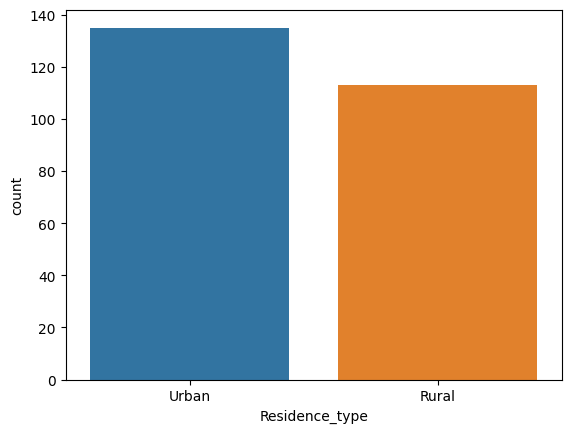

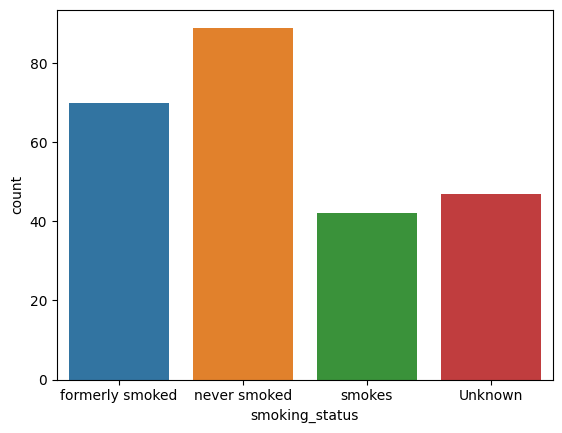

In [15]:
for col in categorical_col:
    sns.countplot(data=df[df["stroke"]=="Yes"],x=col)
    plt.show()

In [16]:
numerical_cols=df.select_dtypes(include=np.number).columns.to_list()

In [17]:

def Viz_NumericalFeature(data,feature):
  f,(ax_box,ax_hist)=plt.subplots(2,sharex=True,gridspec_kw={'height_ratios':(0.2,0.8)})
  f.set_figheight(6)
  f.set_figwidth(6)
  sns.boxplot(data=data,x=feature,ax=ax_box)
  sns.histplot(data=data,x=feature,ax=ax_hist,kde=True,hue="stroke")
  plt.show()


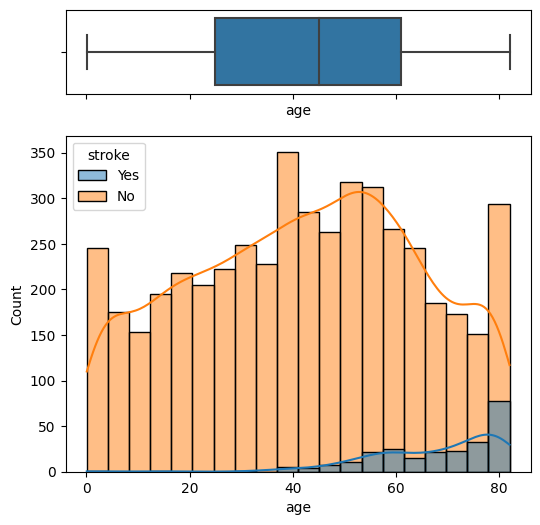

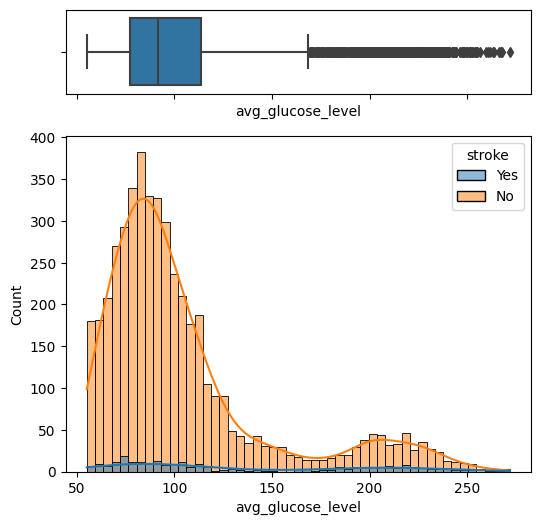

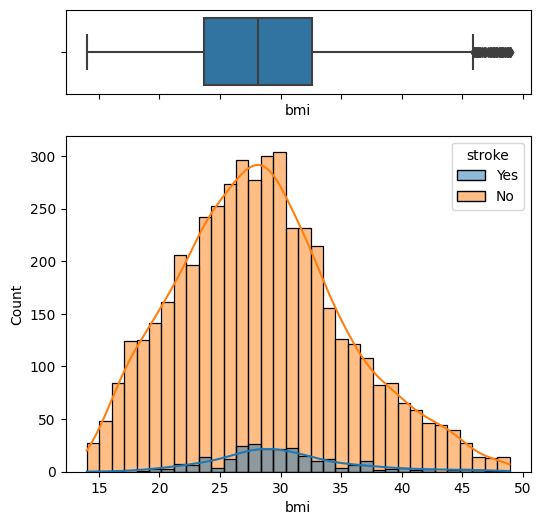

In [18]:
for col in numerical_cols:
    Viz_NumericalFeature(df,col)

Check outlier

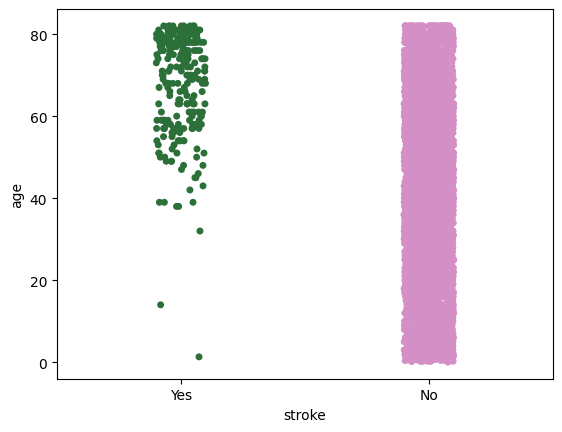

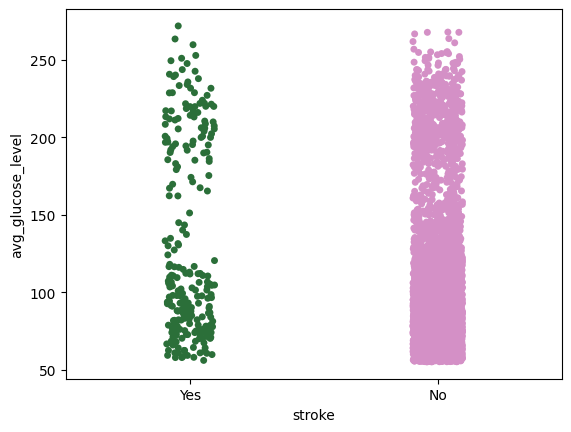

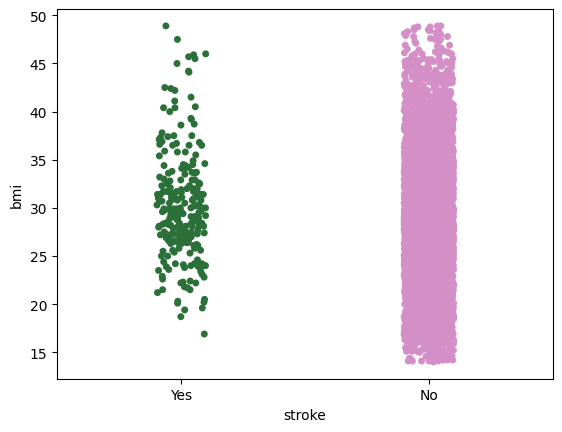

In [19]:
for col in numerical_cols:
    sns.stripplot(y=col, x ="stroke", data = data, palette='cubehelix')
    plt.show()

# In[4]: PART 4. PREPARE THE DATA 

## Encoding categorical features

In [20]:
categorical_cols=df.select_dtypes(include=["object"]).columns.to_list()


In [21]:
categorical_cols

['gender',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'Residence_type',
 'smoking_status',
 'stroke']

In [22]:
binary_encoder_cols=[col for col in categorical_cols if len(df[col].unique())==2]

In [23]:
# Processing features has 2 values
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
for col in binary_encoder_cols:
    df[col]=lb.fit_transform(df[col])

In [24]:
# Processing features has more 2 values
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for col in categorical_cols:
    if col not in binary_encoder_cols:
        df[col]=le.fit_transform(df[col])

In [25]:
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,1,1,228.69,36.6,1,1
1,1,80.0,0,1,1,1,0,105.92,32.5,2,1
2,0,49.0,0,0,1,1,1,171.23,34.4,3,1
3,0,79.0,1,0,1,2,0,174.12,24.0,2,1
4,1,81.0,0,0,1,1,1,186.21,29.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
4976,1,41.0,0,0,0,1,0,70.15,29.8,1,0
4977,1,40.0,0,0,1,1,1,191.15,31.1,3,0
4978,0,45.0,1,0,1,0,0,95.02,31.8,3,0
4979,1,40.0,0,0,1,1,0,83.94,30.0,3,0


## Drop some features that are not important

<AxesSubplot:>

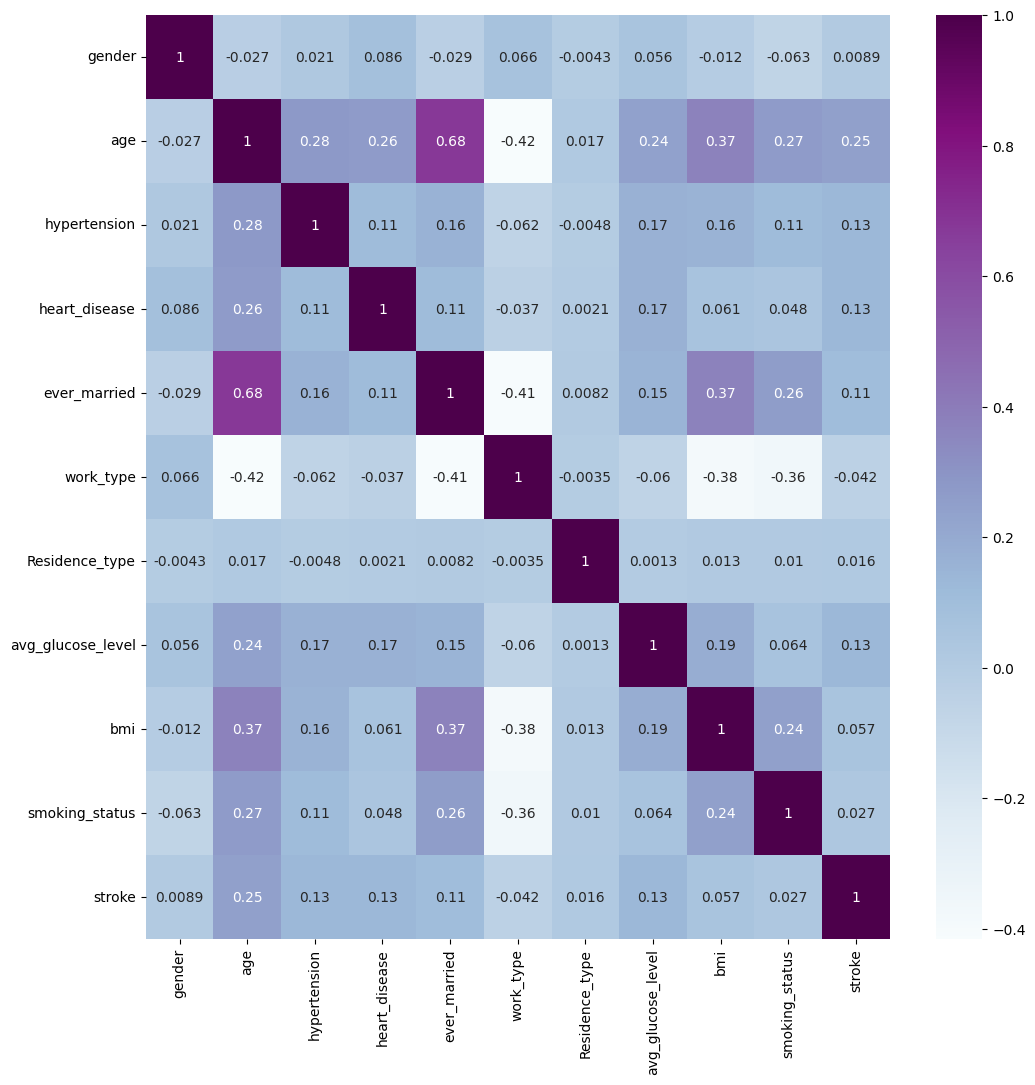

In [26]:
plt.figure(figsize=(12,12))
sns.heatmap(df.corr(),annot=True,cmap="BuPu")

In [27]:
feature_selection=[col for col,value in df.corr()["stroke"].items() if value>0.05]

In [28]:
final_data=df[feature_selection]
final_data

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke
0,67.0,0,1,1,228.69,36.6,1
1,80.0,0,1,1,105.92,32.5,1
2,49.0,0,0,1,171.23,34.4,1
3,79.0,1,0,1,174.12,24.0,1
4,81.0,0,0,1,186.21,29.0,1
...,...,...,...,...,...,...,...
4976,41.0,0,0,0,70.15,29.8,0
4977,40.0,0,0,1,191.15,31.1,0
4978,45.0,1,0,1,95.02,31.8,0
4979,40.0,0,0,1,83.94,30.0,0


## Handling imbalance data 

In [29]:
fig=px.pie(final_data,values=df[target_feature].value_counts(),
           names=["No stroke","stroke"],title="<b>Percentage of People Having Strokes",
           hole=.5,
       color_discrete_sequence=px.colors.qualitative.Pastel,template="plotly")
fig.update_layout(title_font_size=20)
fig.show()

In [30]:
data_handle = final_data.copy()
X=data_handle.drop(columns=target_feature,axis=1)


In [31]:
X

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi
0,67.0,0,1,1,228.69,36.6
1,80.0,0,1,1,105.92,32.5
2,49.0,0,0,1,171.23,34.4
3,79.0,1,0,1,174.12,24.0
4,81.0,0,0,1,186.21,29.0
...,...,...,...,...,...,...
4976,41.0,0,0,0,70.15,29.8
4977,40.0,0,0,1,191.15,31.1
4978,45.0,1,0,1,95.02,31.8
4979,40.0,0,0,1,83.94,30.0


In [32]:
y=data_handle["stroke"]
y

0       1
1       1
2       1
3       1
4       1
       ..
4976    0
4977    0
4978    0
4979    0
4980    0
Name: stroke, Length: 4981, dtype: int32

Normalization

In [33]:
def standarding_numerical(df,numerical_cols):
    from sklearn.preprocessing import StandardScaler
    sc=StandardScaler()
    dict_cs={}
    for col in numerical_cols:
        sc=sc.fit(df[[col]])
        # df[col]=sc.transform(df[[col]])
        dict_cs[col]=sc
    return dict_cs

In [34]:
# from sklearn.preprocessing import StandardScaler
dict_sc=standarding_numerical(X,numerical_cols)
for col in numerical_cols:
    X[[col]]=dict_sc[col].transform(X[[col]])
    

In [35]:
X

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi
0,5.670554,0,1,1,29.484279,1.193238
1,7.585196,0,1,1,11.402697,0.589390
2,3.019512,0,0,1,21.021563,0.869222
3,7.437916,1,0,1,21.447202,-0.662492
4,7.732476,0,0,1,23.227819,0.073909
...,...,...,...,...,...,...
4976,1.841271,0,0,0,6.134487,0.191733
4977,1.693991,0,0,1,23.955383,0.383197
4978,2.430391,1,0,1,9.797344,0.486294
4979,1.693991,0,0,1,8.165480,0.221189


### Under sampling

In [36]:
from imblearn.under_sampling import NearMiss
nm1 = NearMiss(version=1)
X_us, y_us= nm1.fit_resample(X, y)
print(sorted(Counter(y_us).items()))

[(0, 248), (1, 248)]


In [37]:
X_us

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi
0,7.437916,1,0,1,6.701515,0.162277
1,6.848795,0,0,1,11.359986,-0.043915
2,7.585196,0,0,1,6.685314,-0.264835
3,4.345033,0,0,1,8.312760,0.250645
4,7.585196,0,0,1,6.496796,-0.132283
...,...,...,...,...,...,...
491,7.437916,0,0,1,12.706126,-0.191195
492,6.701515,0,0,1,20.417714,0.029725
493,6.996075,1,1,1,25.238193,0.471566
494,6.701515,0,0,1,4.783928,-0.058643


In [38]:
y_us

0      0
1      0
2      0
3      0
4      0
      ..
491    1
492    1
493    1
494    1
495    1
Name: stroke, Length: 496, dtype: int32

In [39]:
from sklearn.model_selection import train_test_split
X_train_us, X_test_us, y_train_us, y_test_us = train_test_split(X_us, y_us, test_size = 0.15, random_state = 0)
print("Information of Train and Test Split : ")
print(X_train_us.shape)
print(y_train_us.shape)
print(X_test_us.shape)
print(y_test_us.shape)

Information of Train and Test Split : 
(421, 6)
(421,)
(75, 6)
(75,)


In [40]:
X_train_us

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi
360,6.996075,0,0,1,16.436732,0.206461
264,6.259675,0,0,1,24.366295,-0.898140
100,4.050473,0,0,1,7.916576,0.294829
487,7.290636,0,0,1,4.738271,-0.205923
295,3.755913,1,0,1,22.450180,-0.117555
...,...,...,...,...,...,...
323,4.197753,0,0,0,5.820780,1.325790
192,7.585196,0,0,1,9.121328,0.839766
117,6.554235,0,0,1,10.714899,0.132821
47,4.492313,0,0,1,8.778165,0.324285


In [41]:
y_train_us

360    1
264    1
100    0
487    1
295    1
      ..
323    1
192    0
117    0
47     0
172    0
Name: stroke, Length: 421, dtype: int32

In [42]:
X_test_us

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi
90,3.019512,0,0,1,10.894581,0.118093
254,5.965115,0,0,0,9.704557,-0.839228
283,3.755913,0,0,1,6.292076,0.000269
443,5.817834,0,0,1,26.887730,1.590895
336,3.166792,1,0,1,6.580745,0.265373
...,...,...,...,...,...,...
142,6.996075,0,0,1,12.149407,0.191733
65,7.143356,0,0,1,6.739808,-0.073371
458,7.290636,0,1,1,28.180850,0.324285
331,5.228714,0,1,1,6.716243,0.044453


In [43]:
y_test_us

90     0
254    1
283    1
443    1
336    1
      ..
142    0
65     0
458    1
331    1
175    0
Name: stroke, Length: 75, dtype: int32

In [44]:
from sklearn.utils.class_weight import compute_sample_weight
y_weights = pd.DataFrame(final_data[target_feature])
y_weights["Weighted"] = compute_sample_weight("balanced",y_weights[target_feature])
display(y_weights.head())
display(y_weights.value_counts())
w_array = y_weights.loc[y_train_us.index]["Weighted"].values

,stroke,Weighted
0,1,10.042339
1,1,10.042339
2,1,10.042339
3,1,10.042339
4,1,10.042339


stroke  Weighted 
0       0.526199     4733
1       10.042339     248
dtype: int64

### Over sampling

In [45]:
X

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi
0,5.670554,0,1,1,29.484279,1.193238
1,7.585196,0,1,1,11.402697,0.589390
2,3.019512,0,0,1,21.021563,0.869222
3,7.437916,1,0,1,21.447202,-0.662492
4,7.732476,0,0,1,23.227819,0.073909
...,...,...,...,...,...,...
4976,1.841271,0,0,0,6.134487,0.191733
4977,1.693991,0,0,1,23.955383,0.383197
4978,2.430391,1,0,1,9.797344,0.486294
4979,1.693991,0,0,1,8.165480,0.221189


In [46]:
from imblearn.over_sampling import SMOTE
model_SMOTE = SMOTE(random_state = 156)
X_os_smote, y_os_smote = model_SMOTE.fit_resample(X, y)

In [47]:
X_os_smote

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi
0,5.670554,0,1,1,29.484279,1.193238
1,7.585196,0,1,1,11.402697,0.589390
2,3.019512,0,0,1,21.021563,0.869222
3,7.437916,1,0,1,21.447202,-0.662492
4,7.732476,0,0,1,23.227819,0.073909
...,...,...,...,...,...,...
9461,5.516197,0,0,1,6.319999,0.064135
9462,3.938426,1,0,1,7.213486,-0.021234
9463,6.060548,0,0,1,31.298742,2.423669
9464,7.696631,0,1,1,26.834668,0.326911


In [48]:
y_os_smote

0       1
1       1
2       1
3       1
4       1
       ..
9461    1
9462    1
9463    1
9464    1
9465    1
Name: stroke, Length: 9466, dtype: int32

In [49]:
from sklearn.model_selection import train_test_split
X_train_os, X_test_os, y_train_os, y_test_os = train_test_split(X_os_smote, y_os_smote, 
                                                                test_size = 0.2, random_state = 0)
print("Information of Train and Test Split : ")
print(X_train_os.shape)
print(y_train_os.shape)
print(X_test_os.shape)
print(y_test_os.shape)

Information of Train and Test Split : 
(7572, 6)
(7572,)
(1894, 6)
(1894,)


In [52]:
def Weight_sample_extract(y_os_smote,y_train_os):
    WeightedDict = {0 : 0.526199 , 1 :  10.042339}
    y_weight_smote = pd.DataFrame(y_os_smote)
    y_weight_smote["Weighted"] = y_weight_smote[target_feature].map(WeightedDict)
    w_array = y_weight_smote.loc[y_train_os.index]["Weighted"].values
    return w_array


## Function draw confusion matrix

In [53]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def ConfusionMatrix(y_test, y_pred):
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(conf_matrix)
    print(classification_report(y_test, y_pred))
    
    fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Greens)
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()
def evalate_model(model,X_test,y_test):
    X_test_us_norm=X_test.copy()
    y_pred = model.predict(X_test_us_norm)
    ConfusionMatrix(y_test, y_pred)

# In[5]: PART 5. TRAIN AND EVALUATE MODELS 

# 1. Under sampling

### Logistic Regression

In [54]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
cv = KFold(n_splits=3, shuffle=True,random_state=37) 
lr_us=LogisticRegression()
score_lr_us = cross_val_score(lr_us, X_train_us, y_train_us, cv=cv, scoring='f1')
score_lr_us

array([0.6779661 , 0.82926829, 0.736     ])

### Support vector machine

In [55]:
svc_us=SVC()
cv = KFold(n_splits=3, shuffle=True,random_state=37) 
score_svc_us = cross_val_score(svc_us, X_train_us, y_train_us, cv=cv, scoring='f1')
score_svc_us

array([0.54      , 0.59405941, 0.54368932])

### XGBoost Classifier

In [56]:
xgb_us = XGBClassifier()
cv = KFold(n_splits=3, shuffle=True,random_state=37) 
score_xgb_us = cross_val_score(xgb_us, X_train_us, y_train_us, cv=cv, scoring='f1')
score_xgb_us

array([0.73529412, 0.73469388, 0.74242424])

### Random forest Classifier

In [57]:
rdf_us=RandomForestClassifier()
cv = KFold(n_splits=3, shuffle=True,random_state=37) 
score_rdf_us = cross_val_score(rdf_us, X_train_us, y_train_us, cv=cv, scoring='f1')
score_rdf_us

array([0.73134328, 0.74074074, 0.72727273])

### KNN Classifier

In [58]:
knn_us=KNeighborsClassifier()
cv = KFold(n_splits=3, shuffle=True,random_state=37) 
score_knn_us = cross_val_score(knn_us, X_train_us, y_train_us, cv=cv, scoring='f1')
score_knn_us

array([0.63157895, 0.6779661 , 0.65      ])

# 2. Over sampling

### Logistic Classifier

In [59]:
cv = KFold(n_splits=3, shuffle=True,random_state=37) 
lr_os=LogisticRegression()
score_lr_os = cross_val_score(lr_os, X_train_os, y_train_os, cv=cv, scoring='f1')
score_lr_os

array([0.775224  , 0.77706526, 0.76312719])

### Support vector machine

In [60]:
cv = KFold(n_splits=3, shuffle=True,random_state=37) 
svc_os=SVC()
score_svc_os = cross_val_score(svc_os, X_train_os, y_train_os, cv=cv, scoring='f1')
score_svc_os

array([0.77672119, 0.78469945, 0.76557191])

### XGBoost Classifier

In [61]:
cv = KFold(n_splits=3, shuffle=True,random_state=37) 
xgb_os=XGBClassifier()
score_xgb_os = cross_val_score(xgb_os, X_train_os, y_train_os, cv=cv, scoring='f1')
score_xgb_os

array([0.93466934, 0.94679612, 0.93671906])

### Random forest Classifier

In [62]:
cv = KFold(n_splits=3, shuffle=True,random_state=37) 
rdf_os=RandomForestClassifier()
score_rdf_os = cross_val_score(rdf_os, X_train_os, y_train_os, cv=cv, scoring='f1')
score_rdf_os

array([0.91708836, 0.9191232 , 0.90223793])

### KNN Classifier

In [63]:
cv = KFold(n_splits=3, shuffle=True,random_state=37) 
knn_os=KNeighborsClassifier()
score_knn_os = cross_val_score(knn_os, X_train_os, y_train_os, cv=cv, scoring='f1')
score_knn_os

array([0.88946396, 0.88454707, 0.87272727])

# In[6]: PART 6. FINE-TUNE MODELS 

In [64]:
def print_search_result(grid_search, model_name = ""):
    print("\n====== Fine-tune " + model_name +" ======")
    print('Best hyperparameter combination: ',grid_search.best_params_)
    print('Best f1 score: ', (grid_search.best_score_))  
    
   

In [69]:
from sklearn.model_selection import GridSearchCV 
# defining parameter range 
param_grid = {"subsample":[0.5, 0.75, 1],
             "colsample_bytree":[0.5, 0.75, 1],
                "max_depth":[2, 6, 8, 12],
                  "min_child_weight":[1,5,15],
               "learning_rate":[0.3, 0.1, 0.03],
               "n_estimators":[100, 50]
              }
grid = GridSearchCV(XGBClassifier(), param_grid, scoring='f1', return_train_score=True, refit = True, verbose = -1,cv=5) 
  
# fitting the model for grid search 
grid.fit(X_train_os, y_train_os) 
# print best parameter after tuning 
print_search_result(grid, model_name="XGBClassifier")


====== Fine-tune XGBClassifier ======
Best hyperparameter combination:  {'colsample_bytree': 0.5, 'learning_rate': 0.3, 'max_depth': 12, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1}
Best f1 score:  0.9530344886561555


# In[7]: PART 7. ANALYZE AND TEST YOUR SOLUTION 

[[912  32]
 [ 53 897]]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       944
           1       0.97      0.94      0.95       950

    accuracy                           0.96      1894
   macro avg       0.96      0.96      0.96      1894
weighted avg       0.96      0.96      0.96      1894



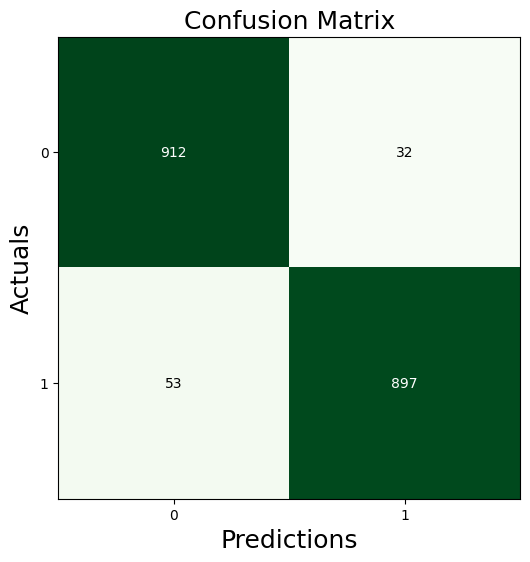

In [71]:
xgboost_model_os=XGBClassifier(colsample_bytree= 0.5, learning_rate= 0.3, max_depth= 12, min_child_weight= 1, n_estimators= 100, subsample= 1)
xgboost_model_os.fit(X_train_os,y_train_os)
evalate_model(xgboost_model_os,X_test_os,y_test_os)

## Add weight

In [72]:
xgboost_model_os_weights = XGBClassifier(colsample_bytree= 0.5, learning_rate= 0.3, max_depth= 12, min_child_weight= 1, n_estimators= 100, subsample= 1)
xgboost_model_os_weights.fit(X_train_os ,y_train_os, sample_weight =  Weight_sample_extract(y_os_smote,y_train_os))

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=12, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

[[836 108]
 [ 32 918]]
              precision    recall  f1-score   support

           0       0.96      0.89      0.92       944
           1       0.89      0.97      0.93       950

    accuracy                           0.93      1894
   macro avg       0.93      0.93      0.93      1894
weighted avg       0.93      0.93      0.93      1894



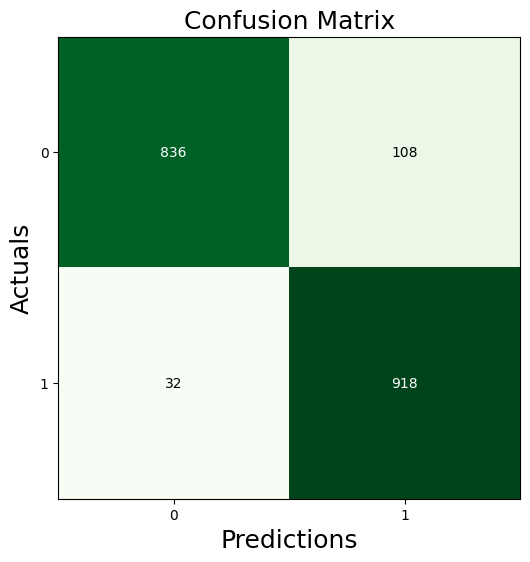

In [73]:
evalate_model(xgboost_model_os_weights,X_test_os,y_test_os)

In [74]:
import dill
filename = "xgboost_model_os_weights.dill"
with open(filename, "wb") as f:
    dill.dump(xgboost_model_os_weights, f)
    print(f"Finish saving models in dill")

Finish saving models in dill


# Sumary:
    Oversampling and XGBoost is highest performance
    